# Lego Detection Model

## Imports

In [71]:
import cv2
import numpy as np
import os
import math
from sklearn.cluster import KMeans
from scripts.utils import *
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

## Defining useful functions for the model

In [72]:

# 1. K-means clustering to get color regions
def kmeansBlur(img, blurQuantity = 3, clusterSize = 10):
    blurred = cv2.GaussianBlur(img, (blurQuantity, blurQuantity), 0)
    
    pixels = blurred.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1.0)
    _, labels, centers = cv2.kmeans(pixels, clusterSize, None, criteria, 12, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((img.shape))
    
    return segmented_image    

def drawEdgeImg(img, edges):
    edge_mask = np.zeros_like(img)
    edge_mask[edges > 0] = (255, 255, 255)
    edge_image = cv2.bitwise_and(img, edge_mask)
    return edge_image

# 2.1 Get the edges of the image with Canny edge detection
def getEdges(img, cannyThreshold1 = 100, cannyThreshold2 = 200, showGray = False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if(showGray):
        print("Gray Image")
        render(gray)
    edges = cv2.Canny(gray, cannyThreshold1, cannyThreshold2)
    edge_image = drawEdgeImg(img, edges)
    return edges, edge_image

# 2.2 
def preprocessImg(og_img, numEdgeIterations = 3, kmeansBlurQuantity = 3, kmeansClusterSize = 10, cannyThreshold1 = 100, cannyThreshold2 = 200, contourConnectSize = 2, debug = False):
    edge_sum = np.zeros(og_img.shape[:2])
    
    for i in range(numEdgeIterations):
        segmented_img = kmeansBlur(og_img, kmeansBlurQuantity, kmeansClusterSize + i)    
        new_edges, _ = getEdges(segmented_img, cannyThreshold1, cannyThreshold2)
        
        """ if debug:
            print(f"Edges Image {i}")
            render(edge_img) """
        
        edge_sum += new_edges

    # Threshold the accumulated edges so that at least 1/2 of iterations agree
    edges = (edge_sum >= (numEdgeIterations / 2)).astype(np.uint8) * 255

    if debug:
        print("Final Edges Image")
        render(drawEdgeImg(og_img, edges))
        
    contour_image, contours = getContours(og_img, edges, contourConnectSize)
    
    if debug:
        print("Contours of the Edges")
        render(contour_image)
        
    return contours


# 3. Get the contours of the edges in the image
def getContours(img, edges, connectSize = 3):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (connectSize, connectSize))
    dilated_edges = cv2.dilate(edges, kernel)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = img.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    return contour_image, contours

# 4.1 Check if two bounding boxes overlap more than a certain threshold
def checkIfBBOverlap(bb1, bb2, intersectionThreshold = 0.2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    intersection_area = max(0, min(x1+w1, x2+w2) - max(x1, x2)) * max(0, min(y1+h1, y2+h2) - max(y1, y2))
    union_area = w1 * h1 + w2 * h2 - intersection_area
    return intersection_area / union_area > intersectionThreshold

# 4.2 Check if bb1 is contained within bb2
def checkIfBBContained(bb1, bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    return x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2

# 4.3 Remove contained bounding boxes
def remove_contained_rectangles(bounding_rectangles):

    if len(bounding_rectangles) < 2:
        return bounding_rectangles
    
    rectangles_to_remove = []

    # Iterate through each pair of bounding boxes
    for i in range(len(bounding_rectangles)):
        for j in range(i + 1, len(bounding_rectangles)):
            
            try:
                bb1 = bounding_rectangles[i]
                bb2 = bounding_rectangles[j]

                # Check if one bounding box is contained within the other
                if checkIfBBContained(bb1, bb2):
                    rectangles_to_remove.append(i)
                elif checkIfBBContained(bb2, bb1):
                    rectangles_to_remove.append(j)
            except:
                continue

    # Remove the contained rectangles
    bounding_rectangles = [bb for i, bb in enumerate(bounding_rectangles) if i not in rectangles_to_remove]

    return bounding_rectangles

# 4.4 Remove overlapping bounding boxes
def remove_overlapping_rectangles(bounding_rectangles, intersection_threshold):

    if len(bounding_rectangles) < 2:
        return bounding_rectangles
    
    # Iterate through each pair of bounding boxes
    for i in range(len(bounding_rectangles)):
        for j in range(i + 1, len(bounding_rectangles)):
            
            try:
                bb1 = bounding_rectangles[i]
                bb2 = bounding_rectangles[j]

                # Check if the bounding boxes overlap more than the threshold
                if checkIfBBOverlap(bb1, bb2, intersection_threshold):
                    
                    # Remove the smallest bounding box of the pair
                    if bb1[2] * bb1[3] < bb2[2] * bb2[3]:
                        bounding_rectangles.remove(bb1)
                    else:
                        bounding_rectangles.remove(bb2)
            except:
                continue

    return bounding_rectangles

# 4.5 Get the bounding boxes for the legos based on the contours edges, removing possible false matches
def getBoundingBoxes(img, contours, minPossibleArea = 100, boundingBoxMaxPossibleAreaRatio = 0.3, intersectionThreshold = 0.2, numEdgeIterations = 3, kmeansBlurQuantity = 3, kmeansClusterSize = 10, cannyThreshold1 = 100, cannyThreshold2 = 200, contourConnectSize = 2, debug = False):
    
    num_legos = 0
    bounding_box_image = img.copy()
    bounding_rectangles = []

    if debug:
        temp = bounding_box_image.copy()
        counter = 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)
            counter += 1
        render(temp)
    
    if counter > 15:
        print("Detected too many bounding boxes, using kmeans again to reduce noise.")
        blurred = cv2.GaussianBlur(img, (9, 9), 0)
        contours = preprocessImg(blurred, numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, cannyThreshold1, cannyThreshold2, contourConnectSize, False)
    
    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        
        # Ignore small area rectangles because they are likely noise
        if area < minPossibleArea:
            continue
        
        # Ignore large area rectangles because they are likely to be the entire image
        if area > boundingBoxMaxPossibleAreaRatio * img.shape[0] * img.shape[1]:
            continue
        
        bounding_rectangles.append((x, y, w, h))
        
    # Sort the bounding boxes by area in descending order
    bounding_rectangles = sorted(bounding_rectangles, key=lambda x: x[2] * x[3], reverse=True)

    # Remove bounding boxes that are contained within other bounding boxes
    bounding_rectangles = remove_contained_rectangles(bounding_rectangles)

    # Check each bb pair and remove the smallest of the pair if they overlap more than threshold
    bounding_rectangles = remove_overlapping_rectangles(bounding_rectangles, intersectionThreshold)
    
    # Draw the bounding boxes on the image
    for x, y, w, h in bounding_rectangles:
        cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        num_legos += 1
        
    return num_legos, bounding_box_image, bounding_rectangles



In [73]:

# 5.1. Get the main frequency colors of the original image
def getMainColors(img, blurQuantity = 3, numColors = 200, showHistogram = False):
    blurred = cv2.GaussianBlur(img, (blurQuantity, blurQuantity), 0)
    bgr = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)
    pixels = bgr.reshape(-1, 3)
    pixel_tuples = [tuple(pixel) for pixel in pixels]

    # Get the most common colors
    color_counter = Counter(pixel_tuples)
    most_common_colors = color_counter.most_common(numColors)
    colors, counts = zip(*most_common_colors)
    colors = np.array(colors)
    
    if showHistogram:
        print("Most common colors histogram")
        plt.bar(range(len(colors)), counts, color=colors/255)
        # make plt bigger
        plt.show()
        
    return colors

# 5.2 Get the image contained in a bounding box
def getBoundingBoxImage(img, box):
    x, y, w, h = box
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image
   

# 5.3. Remove the main colors of the image from the bounding boxes
def remove_similar_colors(img, most_common_colors, blurQuantity = 3, threshold_distance = 100):
    
    replacement_color = (254, 254, 254)
    new_img = img.copy()
    new_img = cv2.GaussianBlur(new_img, (blurQuantity, blurQuantity), 0)

    # Iterate over each pixel in the image and replace the pixel color if it is similar to one of the most common colors
    # for y in range(new_img.shape[0]):
      #   for x in range(new_img.shape[1]):
        #     distances = [np.linalg.norm(np.array(new_img[y, x]) - np.array(color)) for color in most_common_colors]
          #   if min(distances) < threshold_distance:
            #     new_img[y, x] = replacement_color

    return new_img
    
# 5.4 Display a square of a specific color in RGB format
def display_color_square(color):
    color = (color[0] / 255, color[1] / 255, color[2] / 255)
    _, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    rectangle = plt.Rectangle((0, 0), 1, 1, color=color)
    ax.add_patch(rectangle)
    name = f"({color[0] * 255:.0f}, {color[1] * 255:.0f}, {color[2] * 255:.0f})"
    ax.text(0.5, 0.5, name, ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='white'))
    ax.axis('off')
    plt.show()   
    
def getLegoColor(lego_img, colorSimilarityThreshold = 50, numClusters = 8):
    
    
    # use grab cut to to pick the lego out of the image
    mask = np.zeros(lego_img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, lego_img.shape[1], lego_img.shape[0])
    cv2.grabCut(lego_img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    lego_img = lego_img * mask2[:, :, np.newaxis]
    
    # Get the most common colors in the lego image
    colors = getMainColors(lego_img, numColors=100)
    
    # Cluster the colors to get the main color of the lego
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(colors)
    color = kmeans.cluster_centers_[0].astype(int)

    return color

# 6.1 Get the bounding box lego color
def getBBColor(og_img, box, most_common_colors, blurQnt = 5, threshold = 150, showResults = False):
  
    # Extract the bounding box image from the original image
    lego_img = getBoundingBoxImage(og_img, box)
    
    if showResults:
        render(lego_img)
    
    # Remove the background colors from the bounding box image
    lego_img = remove_similar_colors(lego_img, most_common_colors, blurQnt, threshold)
    
    # Get the most common color in the bounding box image, which should be the color of the lego
    color = getLegoColor(lego_img)
    
    # Display the lego image without the background and the lego color
    if showResults:
        render(lego_img)
        try:
            display_color_square(color)
        except:
            print("ERROR: No color was found for this lego piece.")
            color = (0, 0, 0)
        
    return color
    
# 6.2 Number of Different Lego Colors
def getNumDifferentColors(og_img, boxes, most_common_colors, bbColorBlurQnt = 5, bbColorThreshold = 150,  sameColorDistanceThreshold = 20, showResults=False):
    colors = []
    
    def colorDistance(color1, color2):
        return ((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2) ** 0.5

    for box in boxes:
        color = getBBColor(og_img, box, most_common_colors, bbColorBlurQnt, bbColorThreshold, showResults)
        # Check if the color is similar to any previously recorded color
        similar_color_found = False

        for recorded_color in colors:
            if colorDistance(color, recorded_color) <= sameColorDistanceThreshold:
                similar_color_found = True
                break
        if not similar_color_found:
            colors.append(color)
        
    return len(colors), colors


# 7.1 Evaluate results for lego counting
def guessPieceCount(imgID, legoNum, showResults = False):
    # Load the csv file as pd
    df = pd.read_csv("scripts/lego_sets.csv")
    
    # compare legoNum to column piece_count in id row
    piece_count = df.loc[df['id'] == imgID, 'piece_count'].values[0]
    
    if(showResults):
        if(legoNum == piece_count):
            print("Guessed correct number of legos!")
        else:
            (f"Guessed: {legoNum} | Actual: {piece_count} legos") 
        
    return piece_count 

# 7.2 Guess the number of lego colors
def guessColorCount(imgID, colorNum, showResults = False):
    # Load the csv file as pd
    df = pd.read_csv("scripts/lego_sets.csv")
    
    # compare legoNum to column piece_count in id row
    color_arr = df.loc[df['id'] == imgID, 'piece_colors'].values[0]
    
    # Count the number of "-" in the string
    color_count = color_arr.count("-") + 1
    
    if(showResults):
        if(colorNum == color_count):
            print("Guessed correct number of colors!")
        else:
            (f"Guessed: {colorNum} | Actual: {color_count} colors") 
        
    return color_count 



## Defining the model

In [74]:
def model(image_id, debug=False, ignoreColor=False, showBBImg=False):
    
    # Contours Configurations
    kmeansBlurQuantity = 1
    kmeansClusterSize = 8
    cannyThreshold1 = 110
    cannyThreshold2 = 200
    numEdgeIterations = 10
    contourConnectSize = 2
    
    # Bounding Box Configurations
    boundingBoxMinPossibleArea = 200
    boundingBoxMaxPossibleAreaRatio = 0.3
    boundingBoxIntersectionThreshold = 0.25
    
    # BG Color Configurations
    colorBlurStrength = 5
    mainColorQuantity = 150
    
    # BB Color Configurations
    bbColorBlurQnt = 5
    bbColorThreshold = 150
    sameColorDistanceThreshold = 30
    
    # Load the image
    og_img = loadImage(image_id)
    
    if debug:
        print("Original Image")
        render(og_img)
    
    # contours the image to extract the edges and contours
    contours = preprocessImg(og_img, numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, cannyThreshold1, cannyThreshold2, contourConnectSize, debug)
    
    # Bounding box evaluation
    num_legos_guess, bounding_box_image, boxes = getBoundingBoxes(og_img, contours, boundingBoxMinPossibleArea, boundingBoxMaxPossibleAreaRatio, boundingBoxIntersectionThreshold, numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, cannyThreshold1, cannyThreshold2, contourConnectSize, debug)
    
    if debug or showBBImg:
        print("Bounding Boxes: " + str(num_legos_guess))
        render(bounding_box_image)
            
    # Color evaluation
    if not ignoreColor:
        most_common_colors = getMainColors(og_img, colorBlurStrength, mainColorQuantity, debug)
        if debug:
            print("\n================== Color Extraction ==================\n")
        num_colors_guess, color_list = getNumDifferentColors(og_img, boxes, most_common_colors, bbColorBlurQnt, bbColorThreshold, sameColorDistanceThreshold, debug)
        
        if debug:
            print("Colors list: " + str(color_list))
    
    # Make the guesses
    piece_count = guessPieceCount(image_id, num_legos_guess)
    if not ignoreColor:
        color_count = guessColorCount(image_id, num_colors_guess)
    
    if(debug):
        print(f"Lego Count: {num_legos_guess} | {piece_count}")
        if not ignoreColor:
            print(f"Lego Color: {num_colors_guess} | {color_count}")
        
    # Calculate error
    num_legos_error = abs(num_legos_guess - piece_count)
    if not ignoreColor:
        num_colors_error = abs(num_colors_guess - color_count)
    else:
        num_colors_error = 0
        num_colors_guess = 0
        color_count = 0
        
    return piece_count, color_count, num_legos_guess, num_colors_guess, num_legos_error, num_colors_error

## Model Execution on an Image

Original Image


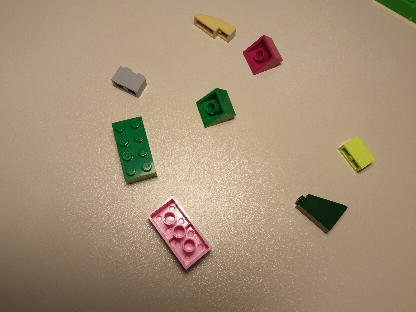

Final Edges Image


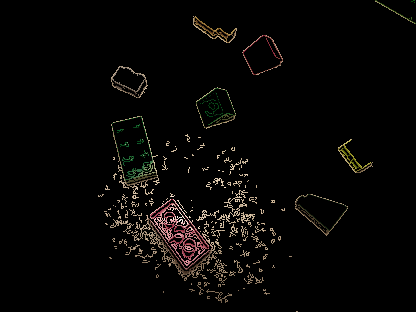

Contours of the Edges


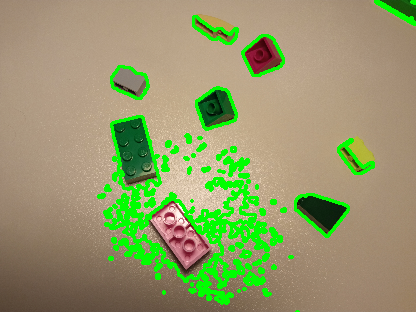

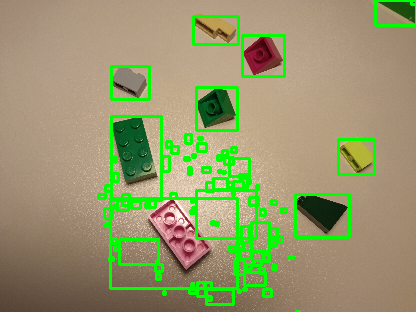

Detected too many bounding boxes, using kmeans again to reduce noise.
Bounding Boxes: 9


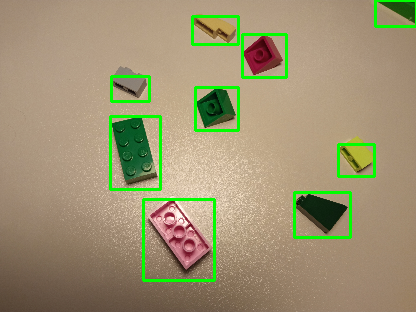

Most common colors histogram


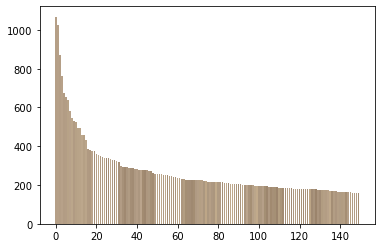


================== Color Extraction ==================



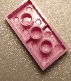

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/grabcut.cpp:386: error: (-215:Assertion failed) !bgdSamples.empty() && !fgdSamples.empty() in function 'initGMMs'


In [75]:
_ = model(11, True)

## Applying the model to all images

In [ ]:
def evaluate_model(debug=False, onlyCheckingNums=False, int1=0, int2=0):
    total_lego_error = 0
    total_color_error = 0
    total_lego = 0
    total_color = 0
    
    error_lego_ids = []

    for i in range(int1, int2):
        print(f"\n======================== Image {i} ========================\n")
        piece_count, color_count, num_legos_guess, num_colors_guess, num_legos_error, num_colors_error = model(i, True, onlyCheckingNums)
        
        if debug:
            if(num_legos_error > 0):
                print(f"Error in Lego Count - Guessed: {num_legos_guess} | Actual: {piece_count} legos")
                error_lego_ids.append(i)
                
            if(num_colors_error > 0):
                print(f"Error in Lego Color - Guessed: {num_colors_guess} | Actual: {color_count} colors")
                error_lego_ids.append(i)
            if num_legos_error == 0 and num_colors_error == 0:
                print("Perfect guess!")
            
        total_lego_error += num_legos_error
        total_color_error += num_colors_error
        total_lego += piece_count
        total_color += color_count
    
    error_lego_ids = set(error_lego_ids)
     
    if debug:    
        print(f"\n\n======================== TOTAL RESULTS ========================")   
        print(f"Total Lego Error: {total_lego_error} | {total_lego}")
        print(f"Total Color Error: {total_color_error} | {total_color}")
        print("Num of images with errors: " + str(len(error_lego_ids)))
        print("Error images: " + str(error_lego_ids))
        print("===============================================================")
        
    return total_lego_error, total_color_error, error_lego_ids

In [ ]:
# _ = evaluate_model(True, False, 11, 15)